# I. Settings and initialisation
## 1.1. Paths

In [1]:
adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211105_Dep1_post/ADCP_proc/sea057_M35_1.ad2cp.00000*.nc'
filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211105_Dep1_post/Oman_deployment_1.pqt'
top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211118_Dep2_post/ADCP/sea057_M38.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211118_Dep2_post/Oman_deployment_2.pqt'
# top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/ADCP/sea057_M40.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/Oman_deployment_3.pqt'
# top_mounted = False

# adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/220126_Dep4_post/ADCP/sea057_M43.ad2cp.00000*.nc'
# filename = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/*220126_Dep4_post/Oman_deployment_4.pqt'
# top_mounted = False

## 1.2. Imports

In [2]:
import importlib, os, gc, sys
from glob import glob

sys.path.append(r'D:/Storage/Repositories/SeaExplorerTools')
import SXBQ as sx
import BYQtools as byq

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo

## 1.3. Settings

In [3]:
import seaborn as sns
sns.set(font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'lightgrey',
         'axes.grid': False,
         'axes.labelcolor': 'darkgrey',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': False,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': False,
         'ytick.right': False},
         font_scale=1)

## 1.4. Helper functions

In [4]:
def RunningMedian(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmedian(grid,axis=1)[N:-N]

def RunningMax(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmax(grid,axis=1)[N:-N]

def RunningMin(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmin(grid,axis=1)[N:-N]

def RunningMean(x,N):
    grid = np.ones((len(x)+2*N, 1 + 2*N ))*np.NaN
    for istep in range(np.shape(grid)[1]):
        grid[istep:len(x)+istep, istep] = x
    return np.nanmean(grid,axis=1)[N:-N]

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

def rmsd(x):
    return np.sqrt(np.nanmean(x**2))

# II. Load glider data

In [5]:
importlib.reload(sx)
# data = sx.sxdf(['D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/PLD/logs/sea057.40.pld1.raw*.gz',
#                 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/NAV/logs/sea057.40.gli.sub*.gz'])
# data.process_basic_variables()
# data.save('D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211220_Dep3_post/Oman_deployment_3.pqt')
data = sx.load(filename)
data.process_basic_variables()

Loaded D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/211105_Dep1_post/Oman_deployment_1.pqt
Parsing GPS data from NAV files and creating latitude and longitude variables.
True GPS values are marked as false in variable "DeadReckoning".


# III. QC and basic processing

## 3.1. Profiles and phases

In [6]:
def delimitateProfiles():

    #data.data.sort_values('Timestamp', ignore_index=True, inplace=True)
    data.median_resample()

    _gd = np.isfinite(data.data['diveNum'].values)
    _, _tmp = np.unique( np.round(data.data['diveNum'].values[_gd]) ,return_inverse=True)

    data.data.loc[_gd,'diveNum'] = np.round(_tmp+1)
    data.data['diveNum'] = data.data['diveNum'].interpolate('nearest')
        
    data.data['profileNum'] = data.data['diveNum'].values*2
    _tmp = data.data['NAV_RESOURCE'].interpolate('nearest').values
    ind = (_tmp == 100) | (_tmp == 110) | (_tmp == 116)
    data.data.loc[ind,'profileNum'] = data.data.loc[ind,'profileNum'] - 1

delimitateProfiles()

## 3.2. T & S
### 3.2.a. Correct RBR pressure bias for this series

In [7]:
def RBR_correction():
    X2 = 1.8e-06
    X3 = -9.472e-10
    X4= 2.112e-13
    Cmeas = data.data.LEGATO_CONDUCTIVITY.values
    Pmeas = data.data.LEGATO_PRESSURE.values
    data.data.LEGATO_CONDUCTIVITY =  Cmeas / (1 + X2*Pmeas + X3*Pmeas**2 + X4*Pmeas**3)
    data.data.LEGATO_SALINITY = gsw.SP_from_C(data.data.LEGATO_CONDUCTIVITY.values, data.data.LEGATO_TEMPERATURE.values, Pmeas)
    print('PRESSURE CORRECTED SALINITY DATA')
    
RBR_correction()

PRESSURE CORRECTED SALINITY DATA


### 3.2.b. TS Lag correction

In [8]:
data = sx.correctSalinityGarau(data) #, coefs=[0.01423066,0.02662347,10.94762768,2.79346268])

Estimating flow speed...
Aligning C-T...
Performing thermal mass correction...
         Assuming a sampling frequency of 1.0004458389328688 Hz.
Beginning regression (slow)...
         Initial minimisation score: 362565.22136853635.
         Final minimisation score: 6.128847599029541e-05.
Regressed coefficients:
[0.01338438 0.02764337 7.22209877 2.79305338]
Applying correction to all data (slow)...


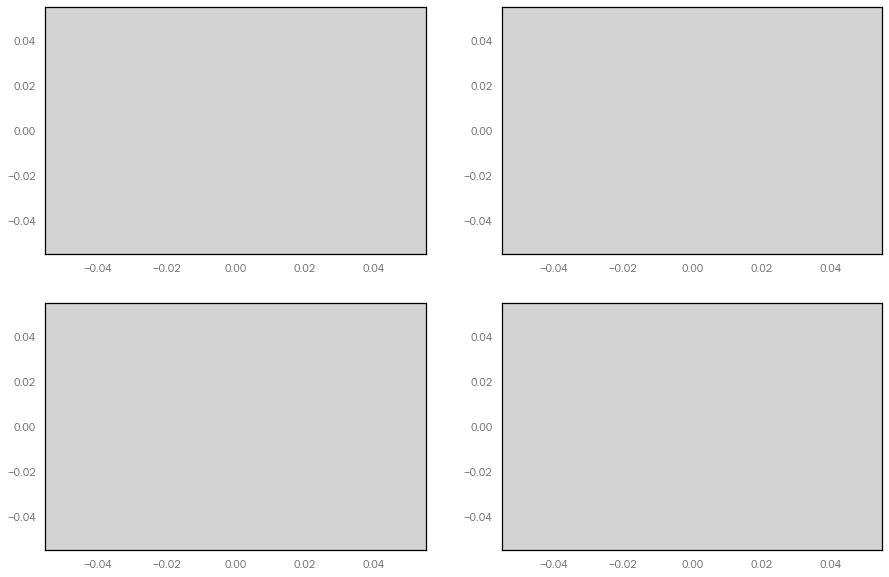

In [9]:
plt.figure(figsize=(15,10))

dives = data.data.diveNum.values
dives = np.unique(dives[np.isfinite(dives)])
dives = np.percentile(dives,[20,40,60,80])

plt.subplot(221)
dn = data.data.diveNum==dives[0]
plt.plot(data.data.LEGATO_SALINITY[dn],data.data.LEGATO_TEMPERATURE[dn],'-r')
plt.plot(data.data.salinity[dn],data.data.temperature[dn],'-b',alpha=0.8)
#plt.xlim([35.5,39])

plt.subplot(222)
dn = data.data.diveNum==dives[1]
plt.plot(data.data.LEGATO_SALINITY[dn],data.data.LEGATO_TEMPERATURE[dn],'-r')
plt.plot(data.data.salinity[dn],data.data.temperature[dn],'-b',alpha=0.8)
#plt.xlim([35.5,39])

plt.subplot(223)
dn = data.data.diveNum==dives[2]
plt.plot(data.data.LEGATO_SALINITY[dn],data.data.LEGATO_TEMPERATURE[dn],'-r')
plt.plot(data.data.salinity[dn],data.data.temperature[dn],'-b',alpha=0.8)
#plt.xlim([35.5,39])

plt.subplot(224)
dn = data.data.diveNum==dives[3]
plt.plot(data.data.LEGATO_SALINITY[dn],data.data.LEGATO_TEMPERATURE[dn],'-r')
plt.plot(data.data.salinity[dn],data.data.temperature[dn],'-b',alpha=0.8)
#plt.xlim([35.5,39])

## 3.3. Calculate derived variables

In [10]:
# Ancillary variables
def _correct_basic_variables(data):
    data['sa'] = gsw.SA_from_SP(data['salinity'],data['LEGATO_PRESSURE'],data['longitude'],data['latitude'])
    data['ct'] = gsw.CT_from_t(data['sa'],data['temperature'],data['LEGATO_PRESSURE'])
    data['sigma0'] = gsw.sigma0(data['sa'],data['ct'])
    
    try:
        data['BB700_smoothed'] = data['FLBBPE_BB_700_SCALED'].copy()
        _gd = np.isfinite(data['FLBBPE_BB_700_SCALED'])
        data.loc[_gd,'BB700_smoothed'] = conv(RunningMin(data['FLBBPE_BB_700_SCALED'][_gd],3),np.ones(7)/7,mode='same')
    except:
        print('No backscatter data')
        
    data['date_float'] = data.Timestamp.values.astype('float')
    return data

data.data = _correct_basic_variables(data.data)

## 3.4. Oxygen (TODO)

In [11]:
# Oxygen todo
# missing lag correction

def _correct_basic_variables(data):
    o2_sol = gsw.O2sol(data['sa'],data['ct'],data['LEGATO_PRESSURE'],data['longitude'],data['latitude'])
    o2_sat =  data['AROD_FT_DO'] / gsw.O2sol( data['sa']*0, data['AROD_FT_TEMP'], data['LEGATO_PRESSURE']*0,data['longitude'],data['latitude'])
    data['o2'] = o2_sat * o2_sol
    return data
    
data.data = _correct_basic_variables(data.data)

## 3.5. Define gridding axis

In [12]:
y_res = 1
yaxis = np.arange(0,np.nanmax(np.ceil(data.data.LEGATO_PRESSURE.values)),y_res)
xaxis = data.data.date_float.groupby(data.data.profileNum).agg('mean').index
taxis = pd.to_datetime(data.data.date_float.groupby(data.data.profileNum).agg('mean').values)
days = np.unique(data.data.Timestamp.round('D'))
   
out = {}

# IV. ADCP Data Processing

## 4.1. Load

In [13]:
ADCP = xr.open_mfdataset(adcp_path,group='Data/Average')
ADCP_settings = xr.open_mfdataset(glob(adcp_path)[0],group='Config')
bin_size = ADCP_settings.attrs['avg_cellSize']
blanking_distance = ADCP_settings.attrs['avg_blankingDistance']

In [14]:
ADCP = ADCP.assign_coords(
    Latitude=("time", 
              interp( data.data['Timestamp'].values.astype('float'), data.data['latitude'], ADCP.time.values.astype('float') ) ))

ADCP = ADCP.assign_coords(
    profileNum=("time", 
                np.round(interp(data.data['Timestamp'].values.astype('float'), data.data['profileNum'], ADCP.time.values.astype('float'))) ))

ADCP = ADCP.assign_coords(
    Depth=("time", -gsw.z_from_p(ADCP['Pressure'].values,ADCP['Latitude'].values)))

ADCP = ADCP.assign_coords(
    bin=("Velocity Range", np.arange(len(ADCP['Velocity Range'].values))))

ADCP = ADCP.swap_dims({'Velocity Range':'bin'})

## 4.2. QC and correction

### 4.2.a. Heading correction

In [15]:
# # Get local geomagnetic target strength:
def getGeoMagStrength():    
    lat = np.nanmedian(data.data.latitude)
    lon = np.nanmedian(data.data.longitude)
    date = pd.to_datetime(np.nanmean(data.data.Timestamp.values.astype('float')))
    year = date.year
    month = date.month
    day = date.day

    url = str('https://www.ngdc.noaa.gov/geomag-web/calculators/calculateIgrfwmm?'+
          'lat1='+str(lat)+'&lon1='+str(lon)+
          '&startYear='+str(year)+'&endYear='+str(year)+
          '&startMonth='+str(month)+'&endMonth='+str(month)+
          '&startDay='+str(day)+'&endDay='+str(day)+
          '&resultFormat=csv')

    import urllib
    magdata = urllib.request.urlopen(url)
    string = 'empty'
    while not not string:
        out = magdata.readline().decode("utf-8")
        if not out:
            break
        string = out
    target = float(string.split(',')[4])
    nT2milligauss = 10**-9 * 10000 * 1000 # To tesla, then to gauss then to millgauss
    print(target*nT2milligauss)
    return target*nT2milligauss


In [16]:
def correctADCPHeading(ADCP):
    target = getGeoMagStrength()
    
    simple = False
    
    roll = ADCP['Roll']
    pitch = ADCP['Pitch']
    
    norm    = lambda x,y,z : np.sqrt(x**2 + y**2 + z**2)
    rmsd    = lambda x,y,z : np.sqrt( np.mean( ( norm(x,y,z) - target)**2 ) )
    
    cosd    = lambda x : np.cos(np.deg2rad(x))
    sind    = lambda x : np.sin(np.deg2rad(x))
    atan2d  = lambda x,y : np.rad2deg(np.arctan2(x,y))
    rot_x   = lambda x,y,z : x*cosd(pitch) + y*sind(roll)*sind(pitch) + z*cosd(roll)*sind(pitch)
    rot_y   = lambda x,y,z : y*cosd(roll) - z*sind(roll)
    wrap    = lambda x : (x+360)%360
    heading = lambda x,y,z : wrap( atan2d(rot_x(x,y,z),rot_y(x,y,z)) - 90 )
    
    def calibrate(x,y,z,coeffs):
        if simple:
            coeffs[[1,2,3,5,6,7]] = 0;
        A = np.reshape(coeffs[:9],(3,3))
        B = coeffs[-3:]
        out = A @ np.array([x-B[0], y-B[1], z-B[2]])
        return out[0,:],out[1,:],out[2,:]
    
    def minimisation(coeffs):
        x,y,z = calibrate(ADCP['MagnetometerX'],ADCP['MagnetometerY'],ADCP['MagnetometerZ'],coeffs)
        return rmsd(x,y,z)
    
    coeffs = fmin(minimisation,np.array([1,0,0,0,1,0,0,0,1,0,0,0]))
    print(np.reshape(coeffs[:9],(3,3)))
    print(coeffs[-3:])
    
    magx,magy,magz = calibrate(ADCP['MagnetometerX'].values, ADCP['MagnetometerY'].values, ADCP['MagnetometerZ'].values,coeffs)
    cal_heading = heading(magx,magy,magz)
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(211)
    plt.plot(cal_heading - ADCP.Heading,'-k')
    plt.plot(cal_heading - heading(ADCP['MagnetometerX'].values, ADCP['MagnetometerY'].values, ADCP['MagnetometerZ'].values),':y',alpha=0.4)
    plt.plot(ADCP.Heading - heading(ADCP['MagnetometerX'].values, ADCP['MagnetometerY'].values, ADCP['MagnetometerZ'].values),'-r.',alpha=0.3)
    plt.ylim([-5,5])
    
    plt.subplot(212)
    plt.plot(norm(ADCP['MagnetometerX'].values, ADCP['MagnetometerY'].values, ADCP['MagnetometerZ'].values),'-k')
    plt.plot(norm(magx,magy,magz),'-b')
    plt.axhline(target)
    
    return cal_heading

441.158
Optimization terminated successfully.
         Current function value: 4.278777
         Iterations: 534
         Function evaluations: 789
[[ 8.24371088e-01 -2.00820947e-02 -1.52203543e-02]
 [ 2.28903387e-04  8.64719979e-01  2.42183527e-02]
 [-1.47807561e-02 -2.28460156e-03  8.63864917e-01]]
[ 0.04287663  0.0052288  -0.02059914]


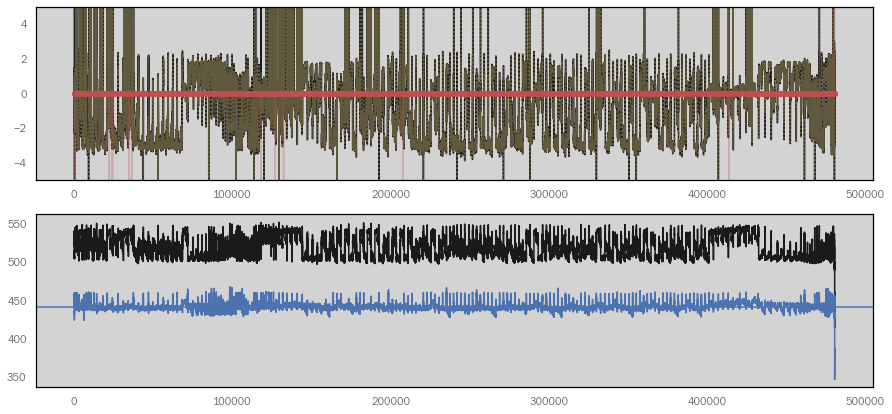

In [17]:
attemptHeadingCorrection = True

if attemptHeadingCorrection:
    ADCP['Heading_old'] = ('time', ADCP['Heading'].values)
    ADCP['Heading'] = ('time', correctADCPHeading(ADCP).values + interp(
            data.data['Timestamp'].values.astype('float'), data.data['Declination'], ADCP.time.values.astype('float')
            ))

### 4.2.b. Sound speed correction (TODO)

In [18]:
# ss,t,p = sx.grid2d(data.data['Timestamp'].values, data.data['pressure'].values, 
#                 gsw.sound_speed(data.data['sa'].values,data.data['ct'].values,data.data['pressure'].values), 
#                 xi=np.timedelta64(60,'m'), yi=1)
# ss = ss.flatten()
# t = t.astype('float').flatten()
# p = p.flatten()
# _gd = np.isfinite(ss)

# ss_q = interp2d(t[_gd],p[_gd],ss[_gd], kind='linear', copy=False, bounds_error=True)

# ADCP_time = np.tile(ADCP['time'].values.astype('float'), (len(ADCP.bin), 1)).T

# # poo = ADCP['V1'] \
# #             * ( ss_q(ADCP_time, ADCP['D1']) \
# #             / np.tile(ADCP['Soundspeed'], (len(ADCP.bin), 1)).T )


# def correctforSoundSpeed():
#     # V(corr) = V(old) * (SoundSpeed(Real)/SoundSpeed(Instrument))

#     ss = gsw.sound_speed(data.data['sa'].values,data.data['ct'].values,data.data['pressure'].values)
#     t = data.data['Timestamp'].values.astype('float')
#     _gd = np.isfinite(ss+t)
#     ss_q = interp1d(t[_gd],ss[_gd], bounds_error=True, fill_value=np.NaN)
    
#     ADCP_time = np.tile(ADCP['time'].values.astype('float'), (len(ADCP.bin), 1)).T
    
#     ADCP['V1'] = ADCP['V1'] \
#             * ( ss_q(ADCP_time, ADCP['D1']) \
#             / np.tile(ADCP['Soundspeed'], (len(ADCP.bin), 1)).T )
#     ADCP['V2'] = ADCP['V1'] \
#             * ( ss_q(ADCP_time, ADCP['D2']) \
#             / np.tile(ADCP['Soundspeed'], (len(ADCP.bin), 1)).T )
#     ADCP['V3'] = ADCP['V1'] \
#             * ( ss_q(ADCP_time, ADCP['D3']) \
#             / np.tile(ADCP['Soundspeed'], (len(ADCP.bin), 1)).T )
#     ADCP['V4'] = ADCP['V1'] \
#             * ( ss_q(ADCP_time, ADCP['D4']) \
#             / np.tile(ADCP['Soundspeed'], (len(ADCP.bin), 1)).T )
    
# # UNTESTED AND UNVALIDATED !!!!!! correctforSoundSpeed()

### 4.2.c. Pitching motion correction (TODO)

In [19]:
def ADCP_rotation_correction():
    ADCP['dPitch_dt'] = (['time'], np.gradient(np.deg2rad(ADCP.Pitch.values),ADCP.time.values.astype('float')/(10**9)))
    dx=0.4
    dz=0.125
    a=47.5
    b=25
    ADCP['VelocityBeam1'] = ADCP['VelocityBeam1'] + ADCP['dPitch_dt']*(-dz * np.sin(np.deg2rad(a)) + dx * np.cos(np.deg2rad(a)))
    ADCP['VelocityBeam3'] = ADCP['VelocityBeam3'] + ADCP['dPitch_dt']*( dz * np.sin(np.deg2rad(a)) + dx * np.cos(np.deg2rad(a)))
    ADCP['VelocityBeam2'] = ADCP['VelocityBeam2'] + ADCP['dPitch_dt']*( dx * np.cos(np.deg2rad(b)) )
    ADCP['VelocityBeam4'] = ADCP['VelocityBeam4'] + ADCP['dPitch_dt']*( dx * np.cos(np.deg2rad(b)) )

# ADCP_rotation_correction()
### NOT RUNNING AS PROBABLY CODED FOR UPWARD FACING ADCP

In [20]:
def ADCP_speed():
    M11=0.6782; M12=0.0000; M13=-0.6782; M14=0.0000
    M21=0.0000; M22=-1.1831; M23=0.0000; M24=1.1831
    M31=0.7400; M32=0.0000; M33=0.7400; M34=0.0000
    M41=0.0000; M42=0.5518; M43=0.0000; M44=0.5518
    T = np.array([[M11,M12,M13,M14], [M21,M22,M23,M24], [M31,M32,M33,M34], [M41,M42,M43,M44]])
    T[1:,:] = -T[1:,:]
    print(T)
    V = np.array([ADCP.isel(bin=0)['VelocityBeam1'],
                  ADCP.isel(bin=0)['VelocityBeam2'],
                  ADCP.isel(bin=0)['VelocityBeam3'],
                  ADCP.isel(bin=0)['VelocityBeam4']
                 ])

    XYZZ = V*0

    for col in np.arange(V.shape[1]):
        XYZZ[:,col] = T@V[:,col]
    XYZ = np.vstack((XYZZ[0:2,:],np.nanmean(XYZZ[2:,:],axis=0)))
    print(np.shape(XYZ))
    
    
    ADCP['GliderSpeed'] = ('time', np.sqrt(np.sum(XYZ**2, axis=0)))
    
ADCP_speed()

[[ 0.6782  0.     -0.6782  0.    ]
 [-0.      1.1831 -0.     -1.1831]
 [-0.74   -0.     -0.74   -0.    ]
 [-0.     -0.5518 -0.     -0.5518]]
(3, 480849)


### 4.2.d. Outlier and poor correlation removal (TODO)

In [21]:
# From Tanaka:
# the velocity was 0.5 m s-1 176 or less,
# the echo intensity (or amplitude) was 75 dB or less,
# the percent-good was 80 or greater,
# the signal-to-noise ratio (SNR) was 20 or greater.

threshold = 70

for beam in ['1','2','3','4']:
    C = ADCP['CorrelationBeam'+beam].values.copy()
    C[C < threshold] = np.NaN
    C[np.isfinite(C)] = 1
    
    ADCP['VelocityBeam'+beam] = ADCP['VelocityBeam'+beam]*C

## 4.3. Calculate depth of ADCP bins

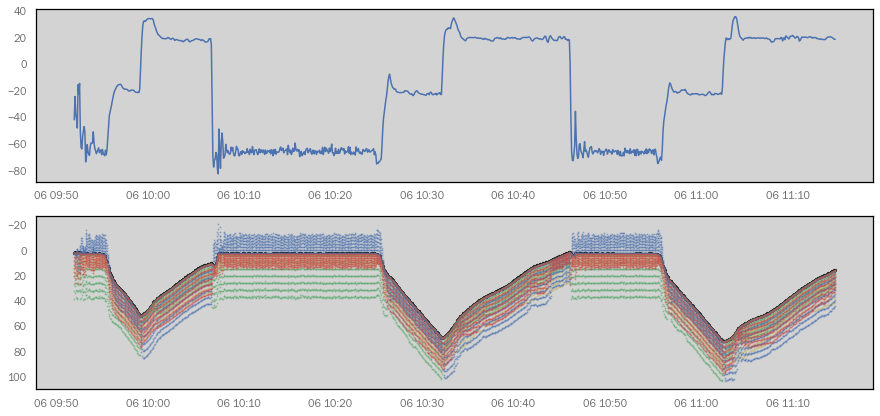

In [22]:
def remapADCPdepth(ADCP, bin_size, blanking_distance, top_mounted=top_mounted):
    if top_mounted:
        direction = 1
        theta_rad_1 = np.arccos(  np.cos(np.deg2rad(47.5 - ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_2 = np.arccos(  np.cos(np.deg2rad(25 -   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        theta_rad_3 = np.arccos(  np.cos(np.deg2rad(47.5 + ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_4 = np.arccos(  np.cos(np.deg2rad(25 +   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
    else:
        direction = -1
        theta_rad_1 = np.arccos(  np.cos(np.deg2rad(47.5 + ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_2 = np.arccos(  np.cos(np.deg2rad(25 +   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        theta_rad_3 = np.arccos(  np.cos(np.deg2rad(47.5 - ADCP['Pitch']))  * np.cos(np.deg2rad(ADCP['Roll']))  )
        theta_rad_4 = np.arccos(  np.cos(np.deg2rad(25 -   ADCP['Roll'] ))  * np.cos(np.deg2rad(ADCP['Pitch']))  )
        
    # Upward facing ADCP, so beam 1 ~= 22 deg on the way up, beam 3 on the way down
    # Returns angles of each beam from the UP direction
    
    
    z_bin_distance = blanking_distance + np.arange(len(ADCP.bin))*bin_size + 0.5*bin_size
    
    ADCP['D1'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                     - direction \
                     * np.tile(z_bin_distance/np.cos(np.deg2rad(47.5)), (len(ADCP.time), 1)) \
                     * np.tile(np.cos(theta_rad_1), (len(ADCP.bin), 1)).T \
                   )
    ADCP['D2'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance/np.cos(np.deg2rad(25)), (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_2), (len(ADCP.bin), 1)).T \
                  )
    ADCP['D3'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance/np.cos(np.deg2rad(47.5)), (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_3), (len(ADCP.bin), 1)).T \
                  )
    ADCP['D4'] = (
                   ['time','bin'],
                   np.tile(ADCP['Depth'], (len(ADCP.bin), 1)).T \
                    - direction \
                    * np.tile(z_bin_distance/np.cos(np.deg2rad(25)), (len(ADCP.time), 1)) \
                    * np.tile(np.cos(theta_rad_4), (len(ADCP.bin), 1)).T \
                  )  
    
    plt.close('all')
    plt.figure(figsize=(15,7))
    x = np.arange(1000)
    b = ADCP.bin.values[0::4]
    
    times = np.tile(ADCP.time[x].values, (len(b), 1)).T
    
    plt.subplot(211)
    plt.plot(ADCP.time[x],ADCP.Pitch[x])
    
    plt.subplot(212)
    plt.scatter(ADCP.time[x],ADCP.Pressure[x],5,'k')
    plt.scatter(times.flatten(),ADCP.isel(time=x, bin=b)['D1'].values.flatten(),1,'g',alpha=0.4)
    plt.scatter(times.flatten(),ADCP.isel(time=x, bin=b)['D2'].values.flatten(),1,'y',alpha=0.4)
    plt.scatter(times.flatten(),ADCP.isel(time=x, bin=b)['D3'].values.flatten(),1,'b',alpha=0.4)
    plt.scatter(times.flatten(),ADCP.isel(time=x, bin=b)['D4'].values.flatten(),1,'r',alpha=0.4)

    plt.gca().invert_yaxis()

    return ADCP

ADCP = remapADCPdepth(ADCP,bin_size,blanking_distance)

## 4.4. Interpolate ADCP velocities onto isobars

Using the following depth offsets:
[ -0.7  -1.7  -2.7  -3.7  -4.7  -5.7  -6.7  -7.7  -8.7  -9.7 -10.7]
 
Running gridding on all 4 beams:


  0%|          | 0/480849 [00:00<?, ?it/s]

  0%|          | 0/480849 [00:00<?, ?it/s]

  0%|          | 0/480849 [00:00<?, ?it/s]

  0%|          | 0/480849 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                    (time: 480849, bin: 25, Correlation Range: 25, Amplitude Range: 25, Physicalbeam_dim: 4, gridded_bin: 11)
Coordinates:
  * time                       (time) datetime64[ns] 2021-10-06T09:51:57.4382...
    Velocity Range             (bin) float32 1.2 2.2 3.2 4.2 ... 23.2 24.2 25.2
  * Correlation Range          (Correlation Range) float32 1.2 2.2 ... 24.2 25.2
  * Amplitude Range            (Amplitude Range) float32 1.2 2.2 ... 24.2 25.2
    Latitude                   (time) float64 23.97 23.97 23.97 ... nan nan nan
    profileNum                 (time) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    Depth                      (time) float64 1.686 1.393 1.567 ... nan nan nan
  * bin                        (bin) int32 0 1 2 3 4 5 6 ... 19 20 21 22 23 24
    depth_offset               (gridded_bin) float64 -0.7 -1.7 ... -9.7 -10.7
    bin_depth                  (time, gridded_bin) float64 2.386 3.386 ... nan
Dimensions without coordinates: Physicalbeam_dim, gridded_bin
Data variables: (12/41)
    TimeStamp                  (time) float64 dask.array<chunksize=(160246,), meta=np.ndarray>
    MatlabTimeStamp            (time) timedelta64[ns] dask.array<chunksize=(160246,), meta=np.ndarray>
    SerialNumber               (time) float64 dask.array<chunksize=(160246,), meta=np.ndarray>
    SpeedOfSound               (time) float32 dask.array<chunksize=(160246,), meta=np.ndarray>
    Error                      (time) float32 dask.array<chunksize=(160246,), meta=np.ndarray>
    ExtendedStatus             (time) float32 dask.array<chunksize=(160246,), meta=np.ndarray>
    ...                         ...
    V2                         (time, gridded_bin) float64 -0.04154 ... nan
    A2                         (time, gridded_bin) float64 82.96 75.87 ... nan
    V3                         (time, gridded_bin) float64 nan nan ... nan nan
    A3                         (time, gridded_bin) float64 nan nan ... nan nan
    V4                         (time, gridded_bin) float64 -0.09828 ... nan
    A4                         (time, gridded_bin) float64 84.01 77.7 ... nan

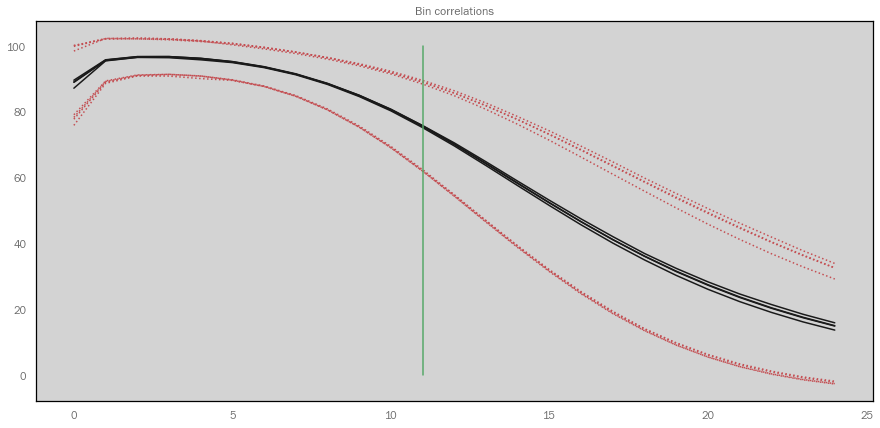

In [23]:
def calc_ideal_depth_offsets(bin_size, blanking_distance):
    if top_mounted:
        direction = 1
    else:
        direction = -1
    threshold = 60
    means = [np.nanmean(ADCP['CorrelationBeam'+str(x)],axis=0) for x in [1,2,3,4]]
    stds = [np.nanstd(ADCP['CorrelationBeam'+str(x)],axis=0) for x in [1,2,3,4]]
    
    max_bin = np.argmin(abs(np.nanmean([means[x]-stds[x] for x in range(4)],axis=0)  - threshold))
    max_distance = blanking_distance + max_bin*bin_size + 0.5*bin_size
    
    plt.close('all')
    plt.figure(figsize=(15,7))
    [plt.plot(means[x],'-k') for x in range(4)]
    [plt.plot(means[x]+stds[x],':r') for x in range(4)]
    [plt.plot(means[x]-stds[x],':r') for x in range(4)]
    plt.plot([max_bin,max_bin],[0,100],'-g')
    plt.title('Bin correlations')
    
    return np.arange(blanking_distance + 0.5*bin_size, max_distance, bin_size)*direction

def regridADCPdata(ADCP, bin_size, blanking_distance, depth_offsets=None):
    if depth_offsets is None:
        depth_offsets = calc_ideal_depth_offsets(bin_size, blanking_distance)
        print('Using the following depth offsets:')
        print(depth_offsets)
        print(' ')
        print('Running gridding on all 4 beams:')
    
    V1 = np.full( (len(ADCP['time']), len(depth_offsets)), np.NaN)
    adcp_depth = ADCP['Depth'].values
    
    for beam in [1,2,3,4]:
        d = ADCP['D'+str(beam)].values
        v = ADCP['VelocityBeam'+str(beam)].values
        a = ADCP['AmplitudeBeam'+str(beam)].values
        x = np.full( (len(ADCP['time']), len(depth_offsets)), np.NaN)
        y = np.full( (len(ADCP['time']), len(depth_offsets)), np.NaN)
        
        for i in tqdm(range(len(ADCP['time']))):
            x[i,:] = interp1d(d[i,:],v[i,:], bounds_error=False, fill_value=np.NaN)(adcp_depth[i] - depth_offsets)
            y[i,:] = interp1d(d[i,:],a[i,:], bounds_error=False, fill_value=np.NaN)(adcp_depth[i] - depth_offsets)
    
        ADCP['V'+str(beam)] = (
            ['time','gridded_bin'],
            x
            )
        ADCP['A'+str(beam)] = (
            ['time','gridded_bin'],
            y
            )
    
    ADCP = ADCP.assign_coords({'depth_offset':(['gridded_bin'], depth_offsets)})
    ADCP = ADCP.assign_coords({'bin_depth':(['time','gridded_bin'], 
                                     np.tile(ADCP['Depth'].values.astype('float'), (len(ADCP.gridded_bin), 1)).T
                                     - np.tile(depth_offsets, (len(ADCP.time), 1))
                                    )})
    
    ADCP = ADCP.drop(labels=['D1','D2','D3','D4',
                             'CorrelationBeam1','CorrelationBeam2','CorrelationBeam3','CorrelationBeam4',
                             'VelocityBeam1','VelocityBeam2','VelocityBeam3','VelocityBeam4',
                             'AmplitudeBeam1','AmplitudeBeam2','AmplitudeBeam3','AmplitudeBeam4'])
    return ADCP

ADCP = regridADCPdata(ADCP, bin_size,blanking_distance)

ADCP

## 4.5. Transform beams to XYZ and ENU velocities

Assuming ADCP is bottom mounted


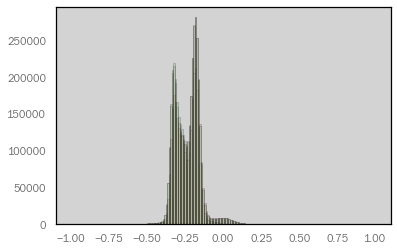

In [24]:
def calcXYZfrom3beam():
    def sin(x):
        return np.sin(np.deg2rad(x))
    def cos(x):
        return np.cos(np.deg2rad(x))

    a = 47.5 # Beam 1 and 3 angle from Z
    b = 25 # Beam 2 and 4 angle from Z

    xyz2beam_fore = np.array([
        [sin(a),0,cos(a)],
        [0,-sin(b),cos(b)],
        [0,sin(b),cos(b)]
    ])
    xyz2beam_aft = np.array([
        [-sin(a),0,cos(a)],
        [0,-sin(b),cos(b)],
        [0,sin(b),cos(b)]
    ])

    beam2xyz_fore = np.linalg.inv(xyz2beam_fore)
    beam2xyz_aft = np.linalg.inv(xyz2beam_aft)

    V_fore = beam2xyz_fore @ np.array([
        ADCP['V1'].values.flatten(),
        ADCP['V2'].values.flatten(),
        ADCP['V4'].values.flatten()
        ])
    V_aft = beam2xyz_aft @ np.array([
        ADCP['V3'].values.flatten(),
        ADCP['V2'].values.flatten(),
        ADCP['V4'].values.flatten()
        ])

    if rmsd(V_aft[1:,:]-V_fore[1:,:]) != 0:
        plt.plot(V_aft[1:,:]-V_fore[1:,:],'-kx')
        print(rmsd(V_aft[1:,:]-V_fore[1:,:]))
        print('Something is wrong - abort and investigate...')

    X_fore = np.reshape( V_fore[0,:] , np.shape(ADCP['V1']) )
    X_aft = np.reshape( V_aft[0,:] , np.shape(ADCP['V1']) )
    
    plt.close('all')
    _ = plt.hist(X_fore.flatten(),np.linspace(-1,1,200),color='r',alpha=0.2)
    _ = plt.hist(X_aft.flatten(),np.linspace(-1,1,200),color='y',alpha=0.2)
    
    use_aft_on_climb = ADCP['Pitch'] > 0
    
    X = X_fore.copy()
    
    if top_mounted == True:
        print('Assuming ADCP is top mounted')
        X[~use_aft_on_climb,:] = X_aft[~use_aft_on_climb,:]
    else:
        print('Assuming ADCP is bottom mounted')
        X[use_aft_on_climb,:] = X_aft[use_aft_on_climb,:]
    
    
    _ = plt.hist(X.flatten(),np.linspace(-1,1,200),color='g',alpha=0.2)
    
    ADCP['X'] = (['time','gridded_bin'], X )
    ADCP['Y'] = (['time','gridded_bin'], np.reshape( V_aft[1,:] , np.shape(ADCP['V1']) ) )
    ADCP['Z'] = (['time','gridded_bin'], np.reshape( V_aft[2,:] , np.shape(ADCP['V1']) ) )
    
    
calcXYZfrom3beam()
#gc.collect()

In [25]:
def calcENUfromXYZ():
    def M_xyz2enu(heading,pitch,roll):
        hh = np.pi*(heading-90)/180
        pp = np.pi*pitch/180
        rr = np.pi*roll/180

        _H = np.array([
            [np.cos(hh),np.sin(hh),0], 
            [-np.sin(hh),np.cos(hh),0], 
            [0,0,1]
        ])
        _P = np.array([
            [np.cos(pp), 0, -np.sin(pp)] ,
            [0, 1, 0] , 
            [ np.sin(pp), 0, np.cos(pp)]
        ])
        _R = np.array([
            [1, 0, 0] ,
            [0, np.cos(rr), -np.sin(rr)] , 
            [0, np.sin(rr), np.cos(rr)]
        ])

        _M = _H@_P@_R
        return _M

    H = ADCP['Heading'].values
    P = ADCP['Pitch'].values
    R = ADCP['Roll'].values

    # H = interp(data.data['Timestamp'].values.astype('float'), data.data['Heading']+data.data['Declination'], ADCP.time.values.astype('float'))
    # P = interp(data.data['Timestamp'].values.astype('float'), data.data['Pitch'], ADCP.time.values.astype('float'))
    # R = interp(data.data['Timestamp'].values.astype('float'), data.data['Roll'], ADCP.time.values.astype('float'))
    
    
    if top_mounted:
        direction = 1
    else:
        direction = -1
        
    E = ADCP['X'].values.copy()
    N = ADCP['Y'].values.copy()*direction
    U = ADCP['Z'].values.copy()*direction

    r,c = np.shape(E)
    
    for i in tqdm(range(r)):
        XYZ2ENU = M_xyz2enu(H[i],P[i],R[i])
        for j in range(c):
            E[i,j], N[i,j], U[i,j] = XYZ2ENU @ [E[i,j], N[i,j], U[i,j]]

    ADCP['E'] = (['time','gridded_bin'], E )
    ADCP['N'] = (['time','gridded_bin'], N )
    ADCP['U'] = (['time','gridded_bin'], U )

calcENUfromXYZ()
gc.collect()

  0%|          | 0/480849 [00:00<?, ?it/s]

53630

257308 187031


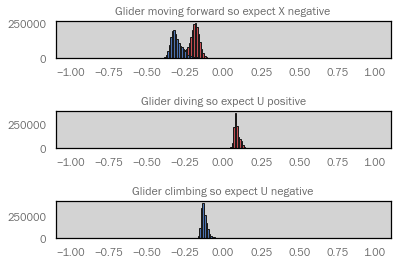

In [26]:
def verify():
    plt.figure()

    PD = (ADCP['Pitch'].values < 0) & (ADCP['Depth'].values > 20)
    PU = (ADCP['Pitch'].values > 0) & (ADCP['Depth'].values > 20)

    print(np.count_nonzero(PD),np.count_nonzero(PU))

    plt.subplot(511)
    _ = plt.hist(ADCP.isel(time=PD)['X'].values.flatten(),np.linspace(-1,1,200),color='r')
    _ = plt.hist(ADCP.isel(time=PU)['X'].values.flatten(),np.linspace(-1,1,200),color='b')
    plt.title('Glider moving forward so expect X negative')

    plt.subplot(513)
    _ = plt.hist(ADCP.isel(time=PD)['U'].values.flatten(),np.linspace(-1,1,200),color='r')
    plt.title('Glider diving so expect U positive')

    plt.subplot(515)
    _ = plt.hist(ADCP.isel(time=PU)['U'].values.flatten(),np.linspace(-1,1,200),color='b')
    plt.title('Glider climbing so expect U negative')
    
verify()

## 4.6. Calculate shear

In [27]:
ADCP['Sh_E'] = (['time','gridded_bin'],
                  ADCP['E'].differentiate('gridded_bin').values
                 )
ADCP['Sh_N'] = (['time','gridded_bin'],
                  ADCP['N'].differentiate('gridded_bin').values
                 )
ADCP['Sh_U'] = (['time','gridded_bin'],
                  ADCP['U'].differentiate('gridded_bin').values
                 )

# V. Flight model regression

## 5.1. Regress model and extract flight speeds

Should I lowpass filter velocities with a filter freq equal to N?

In [28]:
def flight_model():      
    importlib.reload(sx)
    
    # time, sal, temp_ext, temp_int, pres_ext, pres_int, lon, lat, ballast, pitch, profile, navresource, tau, adcp_speed, **param
    flight = sx.SemiDynamicModel(
           data.data.Timestamp, 
           data.data.salinity.interpolate('index').fillna(method='bfill').values, 
           data.data.temperature.interpolate('index').fillna(method='bfill').values, 
           data.data.Temperature.interpolate('index').fillna(method='bfill').values, 
           data.data.LEGATO_PRESSURE.interpolate('index').fillna(method='bfill').values, 
           data.data.Pa.interpolate('index').fillna(method='bfill').values, 
           data.data.longitude.interpolate('index').fillna(method='bfill').values, 
           data.data.latitude.interpolate('index').fillna(method='bfill').values, 
           data.data.BallastPos.interpolate('index').fillna(method='bfill').values, 
           data.data.Pitch.interpolate('index').fillna(method='bfill').values, 
           data.data.profileNum.interpolate('nearest').fillna(method='bfill').values,
           data.data.NAV_RESOURCE.interpolate('nearest').fillna(method='bfill').values,
           0.5,
           interp(ADCP.time.values.astype('float'), ADCP.GliderSpeed, data.data.Timestamp.values.astype('float')),
           mass=60.772, vol0=0.059077990061655435, 
           Cd_0=0.068891783927366, Cd_1=0.8210920513705997, Cl=1.9140152638563785, 
           comp_p=4.4e-06, comp_t=6.973743090064374e-05, 
           lag_t=0.55, SSStau=13)
    
    #flight.regression_parameters = ('Cd_0','Cd_1','Cl','vol0','comp_t', 'SSStau') # 'Cd_0','Cd_1','Cl','SSStau',     
    flight.regression_parameters = ('Cd_0','Cd_1','Cl','vol0','comp_p','comp_t') # 'Cd_0','Cd_1','Cl','SSStau', 
    flight._valid[data.data.LEGATO_PRESSURE < 3] = False
    # flight._valid[data.data.LEGATO_PRESSURE > 100] = False
    flight.regress()

    data.data['alpha'] = flight.alpha
    data.data['speed'] = flight.speed
    data.data['speed_vert'] = flight.speed_vert
    data.data['speed_horz'] = flight.speed_horz
    data.data['w_H2O'] = flight.w_H2O

    return flight

flight = flight_model()

D:\Storage/Repositories/SeaExplorerTools\SXBQ.py:452: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * _dynamic_pressure / self.rho / self.area_w)


Number of valid points: 2004387 (out of 2401910)
Initial parameters:  {'mass': 60.772, 'vol0': 0.059077990061655435, 'area_w': 0.24, 'Cd_0': 0.068891783927366, 'Cd_1': 0.8210920513705997, 'Cl': 1.9140152638563785, 'comp_p': 4.4e-06, 'comp_t': 6.973743090064374e-05, 'SSStau': 13, 'lag_t': 0.55}
Non-optimised score: 0.018404070668524026
Regressing...


 84%|█████████████████████████████████▍      | 251/300 [06:37<01:17,  1.58s/it]


Optimization terminated successfully.
         Current function value: 0.015768
         Iterations: 252
         Function evaluations: 433
Optimised parameters:  {'mass': 60.772, 'vol0': 0.05901378968545028, 'area_w': 0.24, 'Cd_0': 0.06779900549247643, 'Cd_1': 0.6834366303801359, 'Cl': 2.0368650128995083, 'comp_p': 3.202658969779408e-06, 'comp_t': 0.00011592449664691654, 'SSStau': 13, 'lag_t': 0.55}
Final Optimised score: 0.015767693371889744


C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/678477081.py:39: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(V[:,::2],axis=1),yaxis,'-g')
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/678477081.py:40: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(V[:,1::2],axis=1),yaxis,':g')
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/678477081.py:41: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(DZ[:,::2],axis=1),yaxis,'-b')
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/678477081.py:42: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(DZ[:,1::2],axis=1),yaxis,'-b')
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/678477081.py:43: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(SV[:,::2],axis=1),yaxis,':r')
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/678477081.py:44: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(SV[:,1::2],axis=1),yaxis,':r')


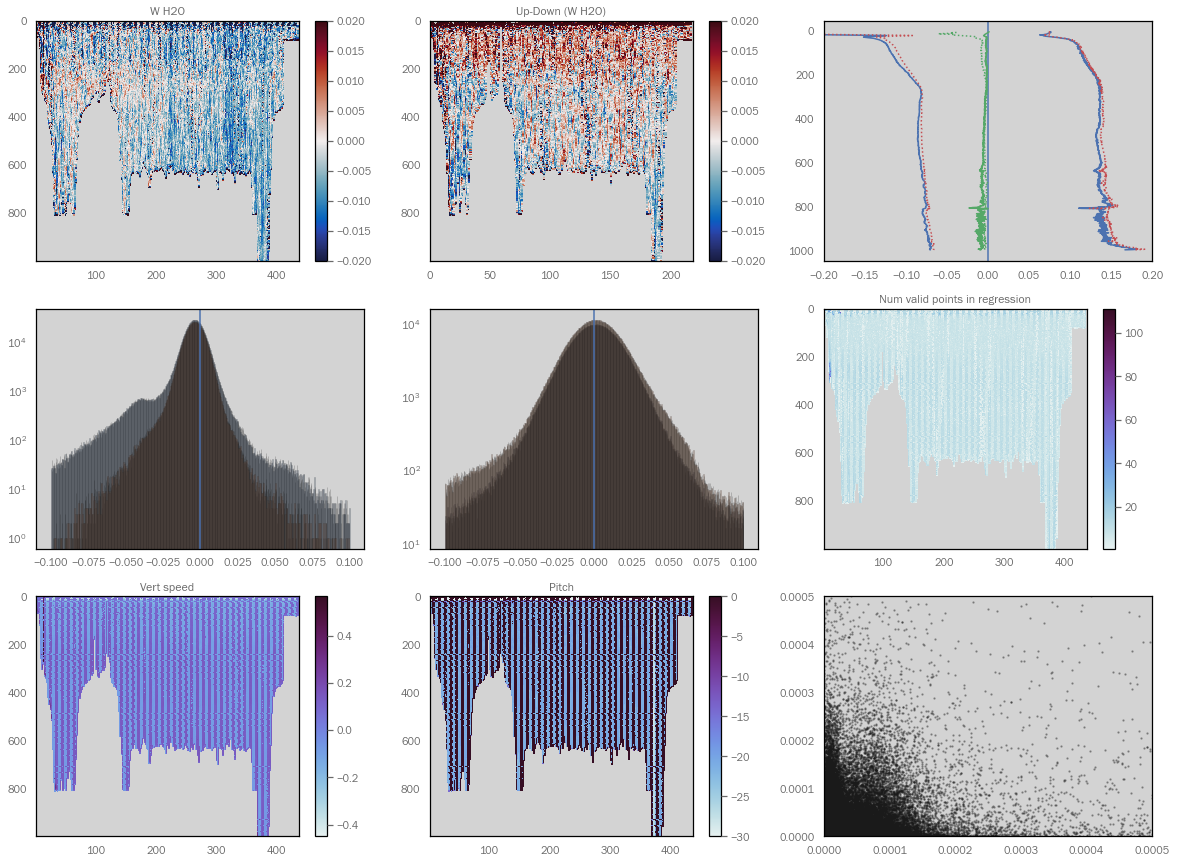

In [29]:
def verify(flight):
    plt.figure(figsize=(20,15))

    yaxis = np.arange(1000)
    mask = flight._valid # & (np.sign(flight.dZdt) == -1)
    
    plt.subplot(331)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.w_H2O[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    DZ,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.dZdt[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    SV,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.speed_vert[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    
    plt.pcolor(XI,YI,V,cmap=cmo.balance,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.clim([-0.02,0.02])
    plt.title('W H2O')
    
    plt.subplot(332)
    plt.pcolor(XI[:,::2]/2,YI[:,::2],V[:,::2]-V[:,1::2],cmap=cmo.balance,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.clim([-0.02,0.02])
    plt.title('Up-Down (W H2O)')
    
    plt.subplot(333)
    plt.axvline(0)
    plt.plot(np.nanmean(V[:,::2],axis=1),yaxis,'-g')
    plt.plot(np.nanmean(V[:,1::2],axis=1),yaxis,':g')
    plt.plot(np.nanmean(DZ[:,::2],axis=1),yaxis,'-b')
    plt.plot(np.nanmean(DZ[:,1::2],axis=1),yaxis,'-b')
    plt.plot(np.nanmean(SV[:,::2],axis=1),yaxis,':r')
    plt.plot(np.nanmean(SV[:,1::2],axis=1),yaxis,':r')
    plt.xlim([-0.2, 0.2])
    plt.gca().invert_yaxis()
    
    plt.subplot(334)
    _ = plt.hist(flight.w_H2O.flatten(), np.linspace(-0.1,0.1,1000),alpha=0.2)
    _ = plt.hist(flight.w_H2O[mask].flatten(), np.linspace(-0.1,0.1,1000),alpha=0.2)
    plt.axvline(0)
    plt.yscale('log')
    
    
    plt.subplot(335)
    _ = plt.hist(flight.speed[mask] - flight.speed_through_water[mask], np.linspace(-0.1,0.1,1000),alpha=0.2)
    _ = plt.hist(flight.speed - flight.speed_through_water, np.linspace(-0.1,0.1,1000),alpha=0.2)
    plt.axvline(0)
    plt.yscale('log')
    
    plt.subplot(336)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight._valid[mask], 
        xi=xaxis, yi=yaxis, fn='sum')
    plt.pcolor(XI,YI,V,cmap=cmo.dense,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    # plt.clim([-0.02,0.02])
    plt.title('Num valid points in regression')
    
    plt.subplot(337)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        flight.dZdt[mask], 
        xi=xaxis, yi=yaxis, fn='mean')
    plt.pcolor(XI,YI,V,cmap=cmo.dense,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    # plt.clim([-0.02,0.02])
    plt.title('Vert speed')
    
    plt.subplot(338)
    V,XI,YI = sx.grid2d(
        data.data.profileNum[mask].values,
        data.data.LEGATO_PRESSURE[mask].values, 
        np.rad2deg(flight.pitch[mask]), 
        xi=xaxis, yi=yaxis, fn='mean')
    plt.pcolor(XI,YI,V,cmap=cmo.dense,shading='auto')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.clim([-30,0])
    plt.title('Pitch')
    
    
    plt.subplot(339)
    V,XI,YI = sx.grid2d(
        data.data.profileNum.values,
        data.data.LEGATO_PRESSURE.values, 
        flight.w_H2O, 
        xi=1, yi=np.arange(0,1000,5), fn='mean')
    SA,_,_ = sx.grid2d(
        data.data.profileNum.values,
        data.data.LEGATO_PRESSURE.values, 
        data.data.sa, 
        xi=1, yi=np.arange(-2.5,1002.5,5), fn='mean')
    CT,_,YI2 =sx.grid2d(
        data.data.profileNum.values,
        data.data.LEGATO_PRESSURE.values, 
        data.data.ct, 
        xi=1, yi=np.arange(-2.5,1002.5,5), fn='mean')
    N2,_ = gsw.Nsquared(SA,CT,YI2)
    
    plt.scatter(N2.flatten(),V.flatten()**2,2,'k',alpha=0.3)
    plt.xlim([0,5e-4])
    plt.ylim([0,5e-4])
    
verify(flight)

## 5.2. Calculate dive-averaged current

No final GPS for dive 218.0


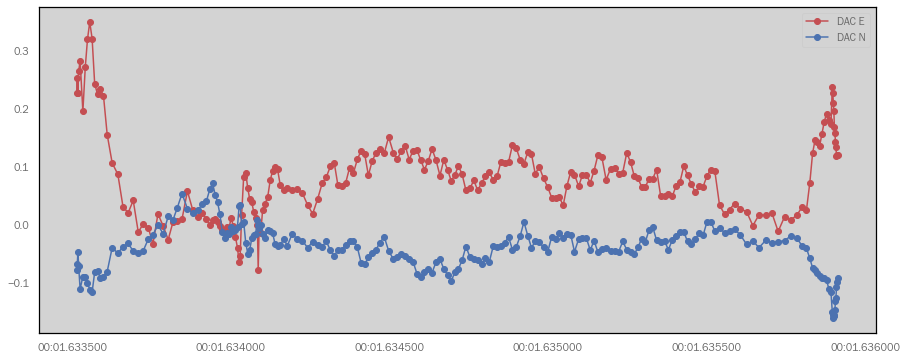

In [30]:
def _getDAC(data):
    ## Calculate full x-y dead reckoning during each dive
    def reset_transport_at_GPS(arr):
        ffill = lambda arr: pd.DataFrame(arr).fillna(method='ffill').values.flatten()
        ref = np.zeros(np.shape(arr)) * np.NaN
        ref[_gps] = arr[_gps]
        return (arr - ffill(ref))
    
    _gps = (data.data.DeadReckoning.values < 1) & (data.data.NAV_RESOURCE.values == 116)
    
    t = data.data.date_float.values * 1e-9
    heading = interp(ADCP['time'].values.astype('float'), ADCP['Heading'].values, data.data.date_float.values)
    # heading = (data.data['Heading'] + data.data['Declination']).interpolate('linear')
    vg_e = np.nan_to_num(data.data['speed_horz'] *np.sin( heading * np.pi/180 ))
    vg_n = np.nan_to_num(data.data['speed_horz'] *np.cos( heading * np.pi/180 ))

    de = np.cumsum(np.append(0, vg_e[1:] * np.diff(t)))
    dn = np.cumsum(np.append(0, vg_n[1:] * np.diff(t)))

    de = reset_transport_at_GPS(de)
    dn = reset_transport_at_GPS(dn)

    ## Calculate on per dive basis
    dnum = np.unique(data.data.diveNum.values)
    sidx = np.zeros(np.shape(dnum))*np.NaN
    didx = np.zeros(np.shape(dnum))*np.NaN
    
    for idx,dx in enumerate(dnum):
        try:
            sidx[idx] = np.flatnonzero((data.data.diveNum.values == dx) & _gps)[0]
            didx[idx] = np.flatnonzero((data.data.diveNum.values == dx) & _gps)[-1]
        except:
            continue
                        
    _gd = np.isfinite(sidx+didx+dnum)
    dnum = dnum[_gd]
    sidx = sidx[_gd]
    didx = didx[_gd]
    
    sidx = sidx.astype(int)
    didx = didx.astype(int)
   
    surf_lat = data.data.latitude.values[sidx]
    surf_lon = data.data.longitude[sidx]
    surf_time = t[sidx]

    dive_lat = data.data.latitude[didx]
    dive_lon = data.data.longitude[didx]
    dive_time = t[didx]

    dr_e = np.zeros(np.shape(dnum)) * np.NaN
    dr_n = np.zeros(np.shape(dnum)) * np.NaN
    gps_e = np.zeros(np.shape(dnum)) * np.NaN
    gps_n = np.zeros(np.shape(dnum)) * np.NaN
    dt = np.zeros(np.shape(dnum)) * np.NaN
    meant = np.zeros(np.shape(dnum)) * np.NaN

    lon2m = lambda x,y : gsw.distance([x,x+1],[y,y])
    lat2m = lambda x,y : gsw.distance([x,x],[y,y+1])
    
    for idx,dx in enumerate(dnum):
        try:
            dr_e[idx] = de[ sidx[idx+1]-1 ]
            dr_n[idx] = dn[ sidx[idx+1]-1 ]
            gps_e[idx] = (surf_lon[idx+1] - dive_lon[idx]) * lon2m(dive_lon[idx],dive_lat[idx])
            gps_n[idx] = (surf_lat[idx+1] - dive_lat[idx]) * lat2m(dive_lon[idx],dive_lat[idx])
            dt[idx] = surf_time[idx+1] - dive_time[idx]
            meant[idx] = (surf_time[idx+1] + dive_time[idx])/2
        except:
            print('No final GPS for dive '+str(dx))

    dac_e = (gps_e-dr_e)/dt
    dac_n = (gps_n-dr_n)/dt
    
    plt.figure(figsize=(15,6))
    plt.plot(pd.to_datetime(meant),dac_e,'o-r')
    plt.plot(pd.to_datetime(meant),dac_n,'o-b')
    plt.legend(('DAC E','DAC N'))

    data.data['DAC_E'] = interp(meant, (gps_e-dr_e)/dt, t)
    data.data['DAC_N'] = interp(meant, (gps_n-dr_n)/dt, t)
    
    data.data['DAC_E'] = data.data['DAC_E'].fillna(method='bfill').fillna(method='ffill')
    data.data['DAC_N'] = data.data['DAC_N'].fillna(method='bfill').fillna(method='ffill')
    
_getDAC(data)

Text(0.5, 1.0, 'North')

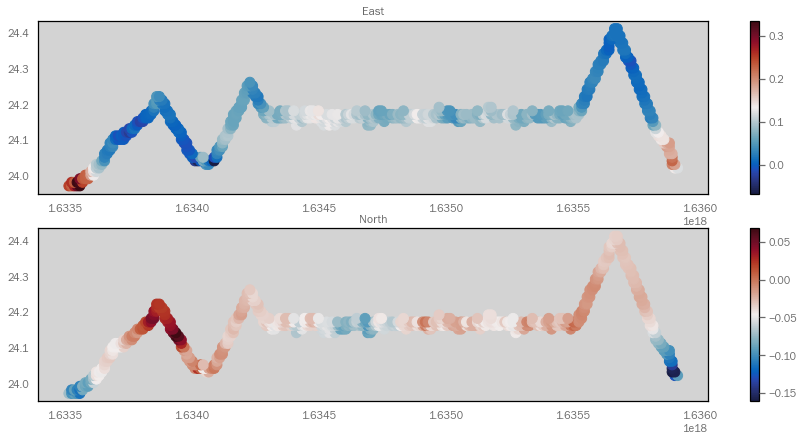

In [31]:
plt.figure(figsize=(15,7))

E,X,Y = sx.grid2d(data.data.Timestamp.values.astype('float'), data.data.latitude, data.data.DAC_E, xi= 10**9 * 60 * 60 * 3, yi=0.01)

N,X,Y = sx.grid2d(data.data.Timestamp.values.astype('float'), data.data.latitude, data.data.DAC_N, xi= 10**9 * 60 * 60 * 3, yi=0.01)

plt.subplot(211)
plt.scatter(X, Y, 100, E, cmap=cmo.balance)
plt.colorbar()
plt.title('East')

plt.subplot(212)
plt.scatter(X, Y, 100, N, cmap=cmo.balance)
plt.colorbar()
plt.title('North')

## 5.3 Get surface drift

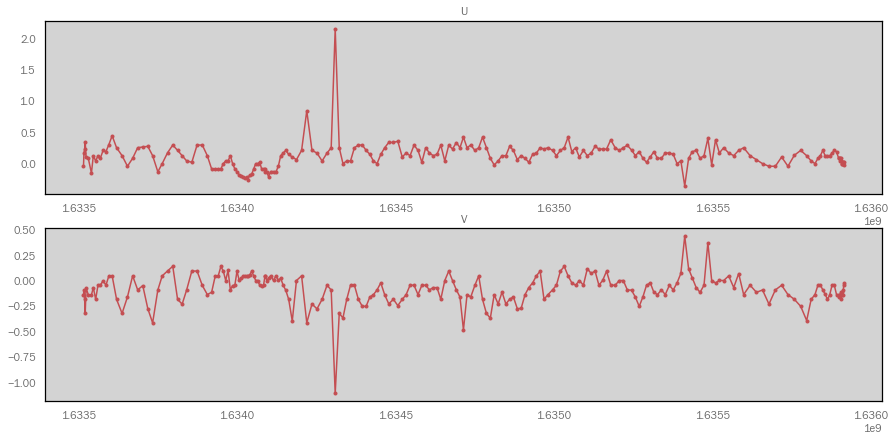

In [32]:
def getSurfaceDrift():
    _gps = (data.data.DeadReckoning.values < 1) & (data.data.NAV_RESOURCE.values == 116)
    
    lon2m = lambda x,y : gsw.distance([x,x+1],[y,y])
    lat2m = lambda x,y : gsw.distance([x,x],[y,y+1])
    
    dnum = data.data.diveNum.values[_gps]
    
    lons = data.data.longitude.values[_gps]
    lats = data.data.latitude.values[_gps]
    
    dlons = np.gradient(lons)
    dlats = np.gradient(lats)
        
    for idx in range(len(lons)):
        dlons[idx] = dlons[idx] * lon2m(lons[idx],lats[idx])
        dlats[idx] = dlats[idx] * lat2m(lons[idx],lats[idx])
    
    times = data.data.Timestamp.values.astype('float')[_gps] / 10**9
    dtimes = np.gradient(times)
    
    dE = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    dN = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    dT = np.full(int(np.nanmax(data.data.diveNum)), np.NaN)
    
    for idx in range(len(dE)):
        _gd = (dtimes < 21) & (dnum == idx+1)
        dE[idx] = np.nanmedian(dlons[_gd]/dtimes[_gd])
        dN[idx] = np.nanmedian(dlats[_gd]/dtimes[_gd])
        dT[idx] = np.nanmean(times[_gd])
    
    
    plt.figure(figsize=(15,7))
    plt.subplot(211)
    plt.plot(dT,dE,'.-r')
    plt.title('U')
    plt.subplot(212)
    plt.plot(dT,dN,'.-r')
    plt.title('V')
    
    
getSurfaceDrift()

## 5.4. Reference ADCP data

C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/724252501.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XI,YI,np.abs(SHEs*100/SHEm))
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/724252501.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(XI,YI,SHEm)
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/724252501.py:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated s

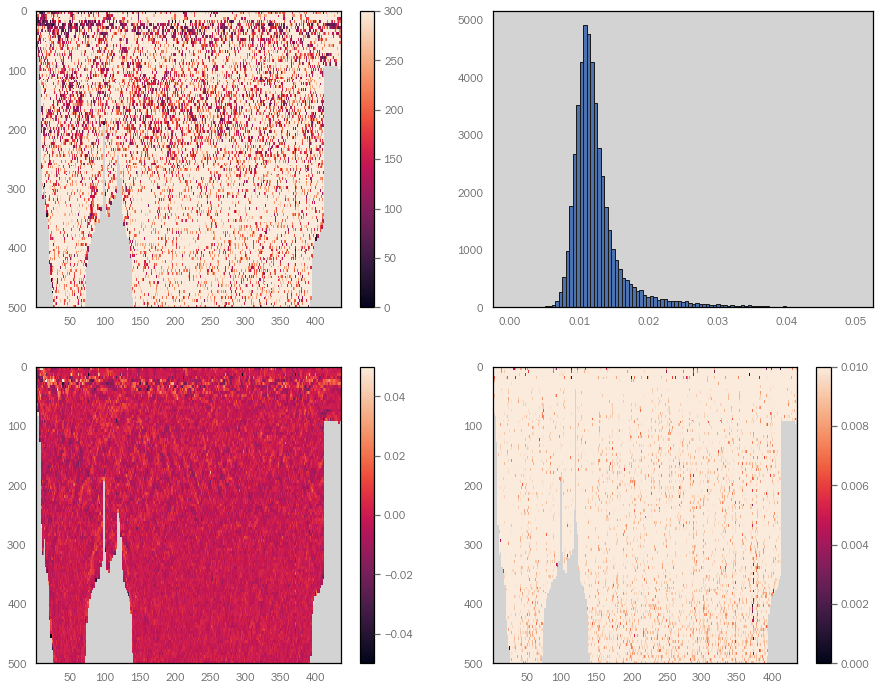

In [33]:
def verify():
    x = np.arange(0,np.shape(ADCP.Sh_E.values)[0],1)

    SHEm,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='mean')
    SHEs,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='std')
    SHEn,XI,YI = sx.grid2d(
        np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T[x,:].flatten(),
        ADCP.bin_depth.values[x,:].flatten(), 
        ADCP.Sh_E.values[x,:].flatten(), 
        xi=1, yi=5, fn='count')

    plt.figure(figsize=(15,12))

    plt.subplot(221)
    plt.pcolor(XI,YI,np.abs(SHEs*100/SHEm))
    plt.colorbar()
    plt.clim([0,300])
    plt.ylim([0,500])
    plt.gca().invert_yaxis()

    plt.subplot(223)
    plt.pcolor(XI,YI,SHEm)
    plt.colorbar()
    plt.ylim([0,500])
    plt.clim([-0.05,0.05])
    plt.gca().invert_yaxis()

    plt.subplot(224)
    plt.pcolor(XI,YI,SHEs)
    plt.colorbar()
    plt.ylim([0,500])
    plt.clim([0,0.01])
    plt.gca().invert_yaxis()

    plt.subplot(222)
    _ = plt.hist(SHEs.flatten(), np.linspace(0,0.05,100))
    
verify()

C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/4213070579.py:22: RuntimeWarning: Mean of empty slice
  V = V - np.tile(np.nanmean(V, axis=0), (np.shape(V)[0],1)) # Make mean of baroclinic profiles equal to 0
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/4213070579.py:46: RuntimeWarning: divide by zero encountered in true_divide
  SpB = y_res / dPdz
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/4213070579.py:54: RuntimeWarning: Mean of empty slice
  Ref = np.nanmean(DAC, axis=0)  -  np.nansum(V*SpB, axis=0)/np.nansum(SpB, axis=0)
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/4213070579.py:54: RuntimeWarning: invalid value encountered in true_divide
  Ref = np.nanmean(DAC, axis=0)  -  np.nansum(V*SpB, axis=0)/np.nansum(SpB, axis=0)
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/2832691761.py:23: RuntimeWarning: Mean of empty slice
  return np.nanmean(grid,axis=1)[N:-N]
C:\Users\bastien\AppData\Local\Temp/ipykernel_6804/4213070579.py:79: RuntimeWarning: Mean of empt

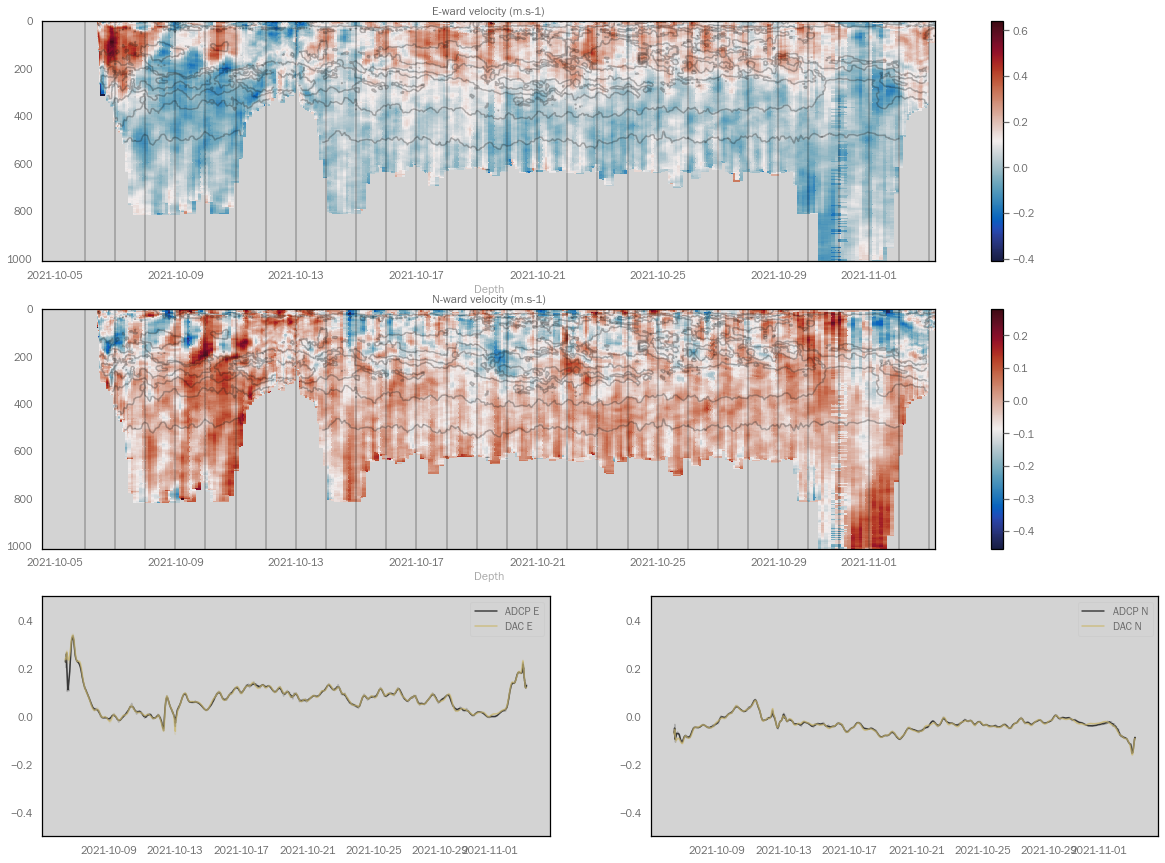

In [34]:
def verify():
    var = ['E','N']
    
    plt.figure(figsize=(20,15))
    
    days = np.unique(data.data.Timestamp.round('D'))
    for pstep in range(len(var)):
        
        letter = var[pstep]
        # Grid shear to average out sensor + zooplankton noise
        Sh,XI,YI = sx.grid2d(
            np.tile(ADCP.profileNum.values, (len(ADCP.gridded_bin), 1)).T.flatten(),
            ADCP.bin_depth.values.flatten(), 
            ADCP['Sh_'+letter].values.flatten(), 
            xi=xaxis, yi=yaxis, fn='mean')

        # Integrate shear vertically
        _bd = ~np.isfinite(Sh) # Preserve what are originally NaN values to recover later as need conversion to 0 for cumsum-
        Sh = np.nan_to_num(Sh) # Replace NaNs with 0 for cumsum
        V = np.cumsum(Sh,axis=0)*y_res # Cumulative sum of shear to recover velocity profile
        V[_bd] = np.NaN # Return NaNs to their rightful place.
        V = V - np.tile(np.nanmean(V, axis=0), (np.shape(V)[0],1)) # Make mean of baroclinic profiles equal to 0

        # Grid DAC
        DAC,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data['DAC_'+letter].values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Grid vertical speed
        dPdz,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data['speed_vert'].values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Grid salinity
        SA,XI,YI = sx.grid2d(
            data.data.profileNum.values,
            data.data.LEGATO_PRESSURE.values, 
            data.data.sa.values, 
            xi=xaxis, yi=yaxis, fn='mean')

        # Seconds spent in each depth bin, to weight referencing
        SpB = y_res / dPdz
        SpB[np.isinf(SpB)] = 0
        strictness = 1
        SpB_std = np.nanstd(SpB.flatten())
        SpB[ np.abs(SpB) > (strictness*SpB_std) ] = strictness*SpB_std

        # Baroclinic velocity, weighted by depth residence time, should be equal to DAC
        # So the reference to add to a baroclinic profile of mean = 0 is the DAC - the weighted baroclinic velocity.    
        Ref = np.nanmean(DAC, axis=0)  -  np.nansum(V*SpB, axis=0)/np.nansum(SpB, axis=0)

        # Now we reference the velocity
        V = V +  np.tile(Ref, (np.shape(V)[0],1))

        # Smooth for cosmetics:
        smoothness = 1
        for istep in range(np.shape(V)[0]):
            V[istep,:] = RunningMean(V[istep,:],smoothness)

        plt.subplot(3,1, pstep+1)
        plt.pcolor(taxis,yaxis,V,cmap=cmo.balance,shading='auto')
        plt.colorbar()
        [plt.axvline(x, color='k', alpha=0.3) for x in days]
        plt.contour(taxis,yaxis,SA,np.linspace(35.5,38.5,6),colors='k',alpha=0.3)
        plt.gca().invert_yaxis()
        plt.clim([-1,1])
        plt.xlabel('Yo number')
        plt.xlabel('Depth')
        plt.title(letter+'-ward velocity (m.s-1)')
        
        out['ADCP_'+letter] = V
    
        plt.subplot(3,2, pstep+5)
        plt.plot(taxis,RunningMean(np.nanmean(V, axis=0),smoothness),'-k',alpha=0.8)
        plt.plot(taxis,RunningMean(np.nanmean(DAC, axis=0),smoothness),'-y',alpha=0.8)
        plt.plot(taxis,np.nanmean(V, axis=0),'-k',alpha=0.2)
        plt.plot(taxis,np.nanmean(DAC, axis=0),'-y',alpha=0.2)
        plt.legend(('ADCP '+letter,'DAC '+letter))
        plt.ylim([-0.5,0.5])
    
    plt.savefig(filename[:filename.rfind('/')+1]+'currents.png', bbox_inches='tight')
    
verify()

# VI. Grid and plot data

In [35]:
def _grid_glider_data(data): 
    
    vars_mean = ['FLBBPE_BB_700_SCALED', 'FLBBPE_CHL_SCALED', 'FLBBPE_PE_SCALED', 'salinity', 'temperature',
                'OCR504_Ed1', 'OCR504_Ed2', 'OCR504_Ed3', 'OCR504_Ed4', 'diveNum', 'longitude', 'latitude', 'sa', 'ct',
                'sigma0', 'o2', 'BB700_smoothed',
                'w_H2O', 'date_float','FLNTU_CHL_SCALED', 'profileNum', 'depth', 'pressure','LEGATO_PRESSURE']
    grid_mean = lambda name : sx.grid2d(data.profileNum.values, data.LEGATO_PRESSURE.values, data[name].values, xi=xaxis, yi=yaxis, fn='mean')[0]

    for varname in tqdm(vars_mean):
        try:
            out[varname] = grid_mean(varname)          
        except:
            print('Variable "'+varname+'" failed to grid.')
    return out

def _plot_glider_data(out):
    # ti = pd.to_datetime(np.nanmean(out['date_float'],axis=1), utc=True, origin='unix', cache='False')
    # print(ti)
    # ti[ti < pd.to_datetime('2021-10-01 00:00:00')] = np.NaN
    
    for varname in tqdm(out.keys()):
        # try:
        plt.close('all')

        plt.figure(figsize=(18,7))

        plt.contourf(taxis,yaxis,out[varname],60,cmap=cmo.haline)
        plt.colorbar()

        plt.contour(taxis,yaxis,out['sigma0'],np.arange(20,40,0.5),colors='w', linestyles='-', linewidths=0.5)

        plt.ylim([0,1000])
        plt.gca().invert_yaxis()
        plt.savefig(filename[:filename.rfind('/')+1]+'deep_'+varname+'.png', bbox_inches='tight')

        plt.ylim([0,150])
        plt.gca().invert_yaxis()
        plt.savefig(filename[:filename.rfind('/')+1]+'shallow_'+varname+'.png', bbox_inches='tight')
        # except:
        #         print('Variable "'+varname+'" failed to plot.')
    plt.close('all')
    return None


In [36]:
out = _grid_glider_data(data.data)

ADCP_pnum = np.tile(ADCP.profileNum, (len(ADCP.gridded_bin),1)).T
out['Sh_E'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_E.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Sh_N'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_N.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]
out['Sh_U'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), ADCP.Sh_U.values.flatten(), xi=xaxis, yi=yaxis, fn='mean')[0]

out['ABS'] = sx.grid2d(ADCP_pnum.flatten(), ADCP.bin_depth.values.flatten(), 
                          (ADCP.A1.values.flatten()+ADCP.A2.values.flatten()+ADCP.A3.values.flatten()+ADCP.A4.values.flatten())/4,
                          xi=xaxis, yi=yaxis, fn='mean')[0]

_plot_glider_data(out)

  0%|          | 0/24 [00:00<?, ?it/s]

Variable "FLNTU_CHL_SCALED" failed to grid.
Variable "depth" failed to grid.
Variable "pressure" failed to grid.


  0%|          | 0/27 [00:00<?, ?it/s]

In [38]:
for key in out:
    print(key)
    np.savetxt(filename[:filename.rfind('/')+1]+key+'.csv', out[key], delimiter=",")

ADCP_E
ADCP_N
FLBBPE_BB_700_SCALED
FLBBPE_CHL_SCALED
FLBBPE_PE_SCALED
salinity
temperature
OCR504_Ed1
OCR504_Ed2
OCR504_Ed3
OCR504_Ed4
diveNum
longitude
latitude
sa
ct
sigma0
o2
BB700_smoothed
w_H2O
date_float
profileNum
LEGATO_PRESSURE
Sh_E
Sh_N
Sh_U
ABS
